In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN

plt.style.use('ggplot')

In [2]:
@contextmanager
def timer(func_name: str):
    """Elapsed Time
    """
    start = time()
    print('[{}][{}] Begin ...'.format(strftime('%Y-%m-%d %H:%M:%S'), func_name))
    yield
    print('[{}][{}] End   ...[Elapsed: {:.2f}s]'.format(strftime('%Y-%m-%d %H:%M:%S'), func_name, time()-start))

In [3]:
train_df,test_df = atecml.data.load()

In [4]:
predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
target = 'Fraud'

In [5]:
#0905-1015 for Train
#1015-11xx for Verification

train_df = atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-10-15')

In [6]:
train_df = atecml.data.fillna_by_DateMedian(train_df)

  0%|          | 0/41 [00:00<?, ?it/s]

[2018-06-23 16:02:28][Fillna by DateMedian] Begin ...


100%|██████████| 41/41 [00:13<00:00,  2.92it/s]


[2018-06-23 16:02:45][Fillna by DateMedian] End   ...[Elapsed: 16.23s]


In [7]:
'''
with timer('PreProcessing: Normalization'):
    scaled_features = StandardScaler().fit_transform(train_df[predictors].values)
    scaled_features_df = pd.DataFrame(scaled_features, index=train_df.index, columns=predictors)
'''    

"\nwith timer('PreProcessing: Normalization'):\n    scaled_features = StandardScaler().fit_transform(train_df[predictors].values)\n    scaled_features_df = pd.DataFrame(scaled_features, index=train_df.index, columns=predictors)\n"

In [8]:
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

model = {}

#model["RandomForest"] = RandomForestClassifier(n_estimators=1000, max_depth=50, n_jobs=-1)
#model["ExtraTree"] =ExtraTreesClassifier(n_estimators=1000, max_depth=50, n_jobs=-1)
model["LightGBM"] = LGBMClassifier(n_estimators=1000, max_depth=50)
#model["GBDT"] =GradientBoostingClassifier(n_estimators=1000, max_depth=50)
#model["XGBOOST"] =XGBClassifier(n_estimators=10, max_depth=5,nthread=80)


def model_train(df, predictors,model_name):
    model_cache_name = './'+model_name+'.model'
    if (os.path.exists(model_cache_name)):
        clf = joblib.load(model_cache_name)
    else:
        params = model_name.split('__')
        model_key = params[0]
        target = params[1]
        clf = model[model_key]
        with atecml.data.timer('> {} <: OverSample for imbalance data'.format(model_key)):
            X_resampled, y_resampled = SMOTE().fit_sample(df[predictors],df[target])
        with atecml.data.timer('> {} <: Training...'.format(model_key)):
            clf.fit(X_resampled,y_resampled)
        joblib.dump(clf,model_cache_name)
    return clf
    

In [9]:
train_model =[]
for idx in range(0,14):
    for item in model.keys():
        for target in ['Normal','Fraud']:
            train_id = item + '__'+target +'__'+str(idx)
            train_model.append(train_id)

trained_model_list =[]
with atecml.data.timer('Classification: Model Training'):
    for train_id in tqdm(range(len(train_model))):
        fit_model = model_train(train_df,predictors,train_model[train_id])
        trained_model_list.append(fit_model)

  7%|▋         | 2/28 [00:00<00:01, 15.16it/s]

[2018-06-23 16:02:49][Classification: Model Training] Begin ...


100%|██████████| 28/28 [00:04<00:00,  5.59it/s]

[2018-06-23 16:02:54][Classification: Model Training] End   ...[Elapsed: 4.84s]


In [10]:
verify_df = atecml.data.load_train()
verify_data = atecml.data.filter_date(verify_df,start_date='2017-10-16',end_date='2018-10-15')

In [11]:
verify_data = atecml.data.fillna_by_DateMedian(verify_data)

'''
with atecml.data.timer('Validation: verify_data fillna'):
    for idx in tqdm(range(len(predictors))):
        item = predictors[idx]
        verify_data[item].fillna(verify_data[item].min(), inplace=True)
'''

  0%|          | 0/21 [00:00<?, ?it/s]

[2018-06-23 16:03:02][Fillna by DateMedian] Begin ...


100%|██████████| 21/21 [00:06<00:00,  3.02it/s]


[2018-06-23 16:03:10][Fillna by DateMedian] End   ...[Elapsed: 8.05s]


"\nwith atecml.data.timer('Validation: verify_data fillna'):\n    for idx in tqdm(range(len(predictors))):\n        item = predictors[idx]\n        verify_data[item].fillna(verify_data[item].min(), inplace=True)\n"

In [12]:
verify_df =pd.DataFrame()
with atecml.data.timer('Validation: Modelfit'):
    for idx in tqdm(range(len(trained_model_list))):
        clf = trained_model_list[idx]
        y_predict = clf.predict_proba(np.array(verify_data[predictors]))
        model_params = train_model[idx].split('__')
        if (model_params[1] == 'Fraud'):
            verify_df[idx] = pd.DataFrame(y_predict)[1]
        else:
            verify_df[idx] = pd.DataFrame(y_predict)[0]

  0%|          | 0/28 [00:00<?, ?it/s]

[2018-06-23 16:03:12][Validation: Modelfit] Begin ...


100%|██████████| 28/28 [02:40<00:00,  5.70s/it]

[2018-06-23 16:05:53][Validation: Modelfit] End   ...[Elapsed: 160.25s]


In [13]:
verify_df['mean']=verify_df.T.mean()

In [14]:
from sklearn.metrics import roc_curve, auc
def performance(y_test,y_predict_proba):
    """
    基于ROC的模型性能测量，并根据蚂蚁金服评分标准输出分数
    """
    fpr, tpr, thresholds = roc_curve(y_test,y_predict_proba)
    roc_auc = auc(fpr, tpr)
    roc_result = pd.DataFrame()
    roc_result['fpr'] = pd.Series(fpr)
    roc_result['tpr'] = pd.Series(tpr)
    roc_result['thresholds'] = pd.Series(thresholds)
    TPR1= float(roc_result[roc_result['fpr']<=0.001002].tail(1)['tpr'])
    TPR2=float(roc_result[roc_result['fpr']<=0.005002].tail(1)['tpr'])
    TPR3=float(roc_result[roc_result['fpr']<=0.010002].tail(1)['tpr'])
    FINAL_SCORE = 0.4*TPR1 + 0.3*TPR2 + 0.3 * TPR3
    print(FINAL_SCORE)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return (FINAL_SCORE,roc_result,roc_auc)

0.48731924360400447


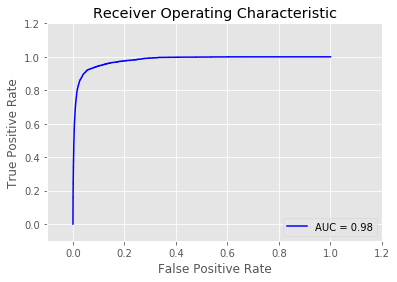

In [15]:
a,b,c=performance(verify_data[target],verify_df['mean'])

In [16]:
test_df = atecml.data.load_test()
test_df = atecml.data.fillna_by_DateMedian(test_df)

  0%|          | 0/32 [00:00<?, ?it/s]

[2018-06-23 16:06:00][Fillna by DateMedian] Begin ...


100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


[2018-06-23 16:06:13][Fillna by DateMedian] End   ...[Elapsed: 13.18s]


In [17]:
predict_df =pd.DataFrame()
with atecml.data.timer('Prediction: Modelfit'):
    for idx in tqdm(range(len(trained_model_list))):
        clf = trained_model_list[idx]
        y_predict = clf.predict_proba(np.array(test_df[predictors]))
        model_params = train_model[idx].split('__')
        if (model_params[1] == 'Fraud'):
            predict_df[idx] = pd.DataFrame(y_predict)[1]
        else:
            predict_df[idx] = pd.DataFrame(y_predict)[0]

  0%|          | 0/28 [00:00<?, ?it/s]

[2018-06-23 16:06:17][Prediction: Modelfit] Begin ...


100%|██████████| 28/28 [03:49<00:00,  8.01s/it]

[2018-06-23 16:10:06][Prediction: Modelfit] End   ...[Elapsed: 229.44s]


In [18]:
predict_df['mean']=predict_df.T.mean()

In [19]:
result=pd.concat([test_df['id'],predict_df['mean']],axis=1)

In [20]:
result.set_index('id').to_csv('./submit_20180623.csv')